# Flux with MNIST


## Libraries

In [1]:
#using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();


In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### tanh

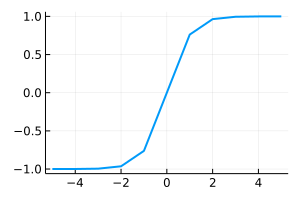

In [7]:
plot(-5:5, tanh.(-5:5), size=(300,200), linewidth=2, legend=false)


### Model

Stochastic Gradient Descent (SGD) means batchsize=1.

The error on every and each data line is computed, then weights are recalculated towards the negative of the gradient.

For this reason, calculation is done at CPU (sequencial computation over one data point at a time).

In [44]:
# model configuration
nInputs  = d
nOutputs = 10
model = Chain( Flux.Dense(nInputs, nOutputs, tanh),   # tanh is chosen as nonlinearity (Prof Mostafa lecture)
               softmax )                              # softmax scales the output to sum to one

losses(X, y)    = Flux.mse( model(X), y )
modelParameters = Flux.params(model)
dataLoader      = Flux.DataLoader((X, y), batchsize=1)             # default batchsize=1
callBack        = Flux.throttle(() -> println("training"), 10);    # print every 10s


### Train

In [63]:
vec=Vector{Float64}()
push!(vec, 45)

1-element Vector{Float64}:
 45.0

In [76]:
function trainModel!(p, data, opt; epochs=20)
    lVec = Vector{Float64}()
    
    for epoch in 1:epochs
        for d in data
            #display(d)
            gs = Flux.gradient(p) do
                l = losses(d...) |> Float64
                #println(l)
            end
            push!(lVec, l)

            Flux.update!(opt, p, gs)
        end
    end
    return lVec
end

@time trainModel!(modelParameters, dataLoader, Flux.Descent(); epochs=1)

LoadError: UndefVarError: l not defined

In [21]:
?push!

search: push! pushfirst! pushdisplay



```
push!(collection, items...) -> collection
```

Insert one or more `items` in `collection`. If `collection` is an ordered container, the items are inserted at the end (in the given order).

# Examples

```jldoctest
julia> push!([1, 2, 3], 4, 5, 6)
6-element Vector{Int64}:
 1
 2
 3
 4
 5
 6
```

If `collection` is ordered, use [`append!`](@ref) to add all the elements of another collection to it. The result of the preceding example is equivalent to `append!([1, 2, 3], [4, 5, 6])`. For `AbstractSet` objects, [`union!`](@ref) can be used instead.

See [`sizehint!`](@ref) for notes about the performance model.

---

```
push!(ir, x)
```

Append the statement or expression `x` to the IR or block `ir`, returning the new variable. See also [`pushfirst!`](@ref), [`insert!`](@ref).

```
julia> ir = IR();

julia> x = argument!(ir)
%1

julia> push!(ir, xcall(:*, x, x))
%2

julia> ir
1: (%1)
  %2 = %1 * %1
```

---

```
push!(CuContext, ctx::CuContext)
```

Pushes a context on the current CPU thread.

---

```
push!(q::Deque{T}, x)
```

Add an element to the back

---

```
push!(s::IntDisjointSets{T})
```

Make a new subset with an automatically chosen new element x. Returns the new element. Throw an `ArgumentError` if the capacity of the set would be exceeded.

---

```
push!(s::DisjointSets{T}, x::T)
```

Make a new subset with an automatically chosen new element x. Returns the new element.

---

```
push!(h::BinaryHeap, value)
```

Adds the `value` element to the heap `h`.

---

```
push!(sc, k=>v)
```

Argument `sc` is a SortedDict or SortedMultiDict and `k=>v` is a key-value pair. This inserts the key-value pair into the container. If the key is already present, this overwrites the old value. The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(sc, k=>v)
```

Argument `sc` is a SortedDict or SortedMultiDict and `k=>v` is a key-value pair. This inserts the key-value pair into the container. If the key is already present, this overwrites the old value. The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(sc, k)
```

Argument `sc` is a SortedSet and `k` is a key. This inserts the key into the container. If the key is already present, this overwrites the old value. (This is not necessarily a no-op; see below for remarks about the customizing the sort order.) The return value is `sc`. Time: O(*c* log *n*)

---

```
push!(cb::CircularBuffer, data)
```

Add an element to the back and overwrite front if full.

---

```
push!(tree, key)
```

Inserts `key` in the `tree` if it is not present.

---

```
push!(handler::DefaultHandler, filter::Memento.Filter)
```

Adds an new `Filter` to the handler.

---

```
push!(logger::Logger, filter::Memento.Filter)
```

Adds an new `Filter` to the logger.

---

```
push!(logger::Logger, handler::Handler)
```

Adds a new `Handler` to the logger.

---

```
push!(df::DataFrame, row::Union{Tuple, AbstractArray}; promote::Bool=false)
push!(df::DataFrame, row::Union{DataFrameRow, NamedTuple, AbstractDict};
      cols::Symbol=:setequal, promote::Bool=(cols in [:union, :subset]))
```

Add in-place one row at the end of `df` taking the values from `row`.

Column types of `df` are preserved, and new values are converted if necessary. An error is thrown if conversion fails.

If `row` is neither a `DataFrameRow`, `NamedTuple` nor `AbstractDict` then it must be a `Tuple` or an `AbstractArray` and columns are matched by order of appearance. In this case `row` must contain the same number of elements as the number of columns in `df`.

If `row` is a `DataFrameRow`, `NamedTuple` or `AbstractDict` then values in `row` are matched to columns in `df` based on names. The exact behavior depends on the `cols` argument value in the following way:

  * If `cols == :setequal` (this is the default) then `row` must contain exactly the same columns as `df` (but possibly in a different order).
  * If `cols == :orderequal` then `row` must contain the same columns in the same order (for `AbstractDict` this option requires that `keys(row)` matches `propertynames(df)` to allow for support of ordered dicts; however, if `row` is a `Dict` an error is thrown as it is an unordered collection).
  * If `cols == :intersect` then `row` may contain more columns than `df`, but all column names that are present in `df` must be present in `row` and only they are used to populate a new row in `df`.
  * If `cols == :subset` then `push!` behaves like for `:intersect` but if some column is missing in `row` then a `missing` value is pushed to `df`.
  * If `cols == :union` then columns missing in `df` that are present in `row` are added to `df` (using `missing` for existing rows) and a `missing` value is pushed to columns missing in `row` that are present in `df`.

If `promote=true` and element type of a column present in `df` does not allow the type of a pushed argument then a new column with a promoted element type allowing it is freshly allocated and stored in `df`. If `promote=false` an error is thrown.

As a special case, if `df` has no columns and `row` is a `NamedTuple` or `DataFrameRow`, columns are created for all values in `row`, using their names and order.

Please note that `push!` must not be used on a `DataFrame` that contains columns that are aliases (equal when compared with `===`).

# Examples

```jldoctest
julia> df = DataFrame(A=1:3, B=1:3);

julia> push!(df, (true, false))
4×2 DataFrame
 Row │ A      B
     │ Int64  Int64
─────┼──────────────
   1 │     1      1
   2 │     2      2
   3 │     3      3
   4 │     1      0

julia> push!(df, df[1, :])
5×2 DataFrame
 Row │ A      B
     │ Int64  Int64
─────┼──────────────
   1 │     1      1
   2 │     2      2
   3 │     3      3
   4 │     1      0
   5 │     1      1

julia> push!(df, (C="something", A=true, B=false), cols=:intersect)
6×2 DataFrame
 Row │ A      B
     │ Int64  Int64
─────┼──────────────
   1 │     1      1
   2 │     2      2
   3 │     3      3
   4 │     1      0
   5 │     1      1
   6 │     1      0

julia> push!(df, Dict(:A=>1.0, :C=>1.0), cols=:union)
7×3 DataFrame
 Row │ A        B        C
     │ Float64  Int64?   Float64?
─────┼─────────────────────────────
   1 │     1.0        1  missing
   2 │     2.0        2  missing
   3 │     3.0        3  missing
   4 │     1.0        0  missing
   5 │     1.0        1  missing
   6 │     1.0        0  missing
   7 │     1.0  missing        1.0

julia> push!(df, NamedTuple(), cols=:subset)
8×3 DataFrame
 Row │ A          B        C
     │ Float64?   Int64?   Float64?
─────┼───────────────────────────────
   1 │       1.0        1  missing
   2 │       2.0        2  missing
   3 │       3.0        3  missing
   4 │       1.0        0  missing
   5 │       1.0        1  missing
   6 │       1.0        0  missing
   7 │       1.0  missing        1.0
   8 │ missing    missing  missing
```

---

```
push!{T,V}(X::DataValueVector{T}, v::V)
```

Insert `v` at the end of `X`, which registers `v` as a present value.

---

```
push!{T,V}(X::DataValueVector{T}, v::DataValue{V})
```

Insert a value at the end of `X` from a `DataValue` value `v`. If `v` is null then this method adds a null entry at the end of `X`. Returns `X`.


In [9]:
# Flux.train!(loss, params, data, opt; cb)
@time Flux.train!(losses, modelParameters, dataLoader, Flux.Descent())   # single epoch, η = 0.1 (default)
# cpu time (batchsize=1): 3-4s

 27.373544 seconds (59.92 M allocations: 5.018 GiB, 3.40% gc time, 88.62% compilation time)


In [10]:
# preferred for multiple epochs
epochs = 10
@time for i in 1:epochs Flux.train!(losses, modelParameters, dataLoader, Flux.Descent(); cb=callBack) end

training
training
training
training
 30.786460 seconds (83.47 M allocations: 20.269 GiB, 2.50% gc time, 0.69% compilation time)


### Predict

In [11]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end

ŷ = predictOutcome(X);


In [12]:
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 4062     2    35    17    20    74    26    19    47    41
    0  4583    23    12    15    20    14    23    74    17
    5    27  3700   101    21    22    17    42    54    24
    9    13    57  3860     5   148     3    13   107    84
    6     3    83     7  3790    63    24    56    39   140
   11    25    15   102     3  3200    47     8   117    30
   26    10    60    37    38   100  3985     5    40     3
    4    11    78    44     8    22     4  4119    22   156
   20    40   102    69    34    98    22    11  3548    45
    3     5    18    43   155    48     1    90    48  3624

accuracy: 0.916
f1-score: 0.914


### Demo ML

Press CTRL-ENTER on the cell to change.

,,,,,,,

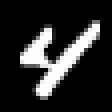
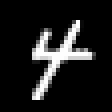
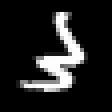
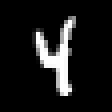
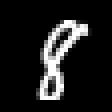
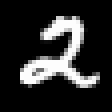
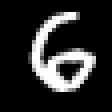
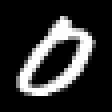

1×8 adjoint(::Vector{Int64}) with eltype Int64:
 4  4  2  4  8  2  6  0

In [13]:
v = rand(1:N, 8)
display([MNIST.convert2image(trainX[:,:,i]) for i in v])
ŷ[v]'